In [1]:
import os
import time
import abc

import jax.tree_util
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
from numpyro.distributions import constraints
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, autoguide

from typing import Any, Callable, Iterable, Optional, Type

In [2]:
%matplotlib inline
matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,      # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,   # thick lines
    "lines.color": "k",     # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,     # higher resolution output.
})

In [3]:
DEVICE = "cpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
D_X = 3

## Data

In [4]:
class Data(abc.ABC):
    @property
    @abc.abstractmethod
    def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError()

    @property
    @abc.abstractmethod
    def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError()

    # @abc.abstractmethod
    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        raise NotImplementedError()

In [15]:
# Reverse dataset
class ReverseData(Data):
    def __init__(self, data: Data):
        self._data = data

    @property
    def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        X, Y = self._data.train
        return X[::-1, ...], Y[::-1, ...]

    @property
    def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        return self._data.test

    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        return self._data.true_predictive(X)

In [16]:
class PermutedData(Data):
    def __init__(self, data: Data, perm: np.array):
        self._data = data
        assert perm.shape[0] == data.train[0].shape[0], "wrong len"
        perm_copy = perm.copy()
        perm_copy.sort()
        assert np.all(perm_copy == np.arange(len(perm))), "not a permutation"
        self._perm = perm

    @property
    def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        X, Y = self._data.train
        return X[self._perm], Y[self._perm]

    @property
    def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        return self._data.test

    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        return self._data.true_predictive(X)

In [5]:
# Define toy regression problem
# create artificial regression dataset
class ToyData1(Data):
    def __init__(self, D_X: int = 3, sigma_obs: float = 0.05, train_size: int = 50, test_size: int = 500):
        self.D_X = D_X
        self.sigma_obs = sigma_obs
        D_Y = 1  # create 1d outputs
        np.random.seed(0)
        X = jnp.linspace(-1, 1, train_size)
        X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
        W = 0.5 * np.random.randn(D_X)
        # y = w0 + w1*x + w2*x**2 + 1/2 (1/2+x)**2 * sin(4x)
        Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
        Y += sigma_obs * np.random.randn(train_size)
        Y = Y[:, np.newaxis]
        Y -= jnp.mean(Y)
        Y /= jnp.std(Y)

        assert X.shape == (train_size, D_X)
        assert Y.shape == (train_size, D_Y)

        X_test = jnp.linspace(-1.3, 1.3, test_size)
        X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

        self._X = X
        self._Y = Y
        self._X_test = X_test
        self._Y_test = None

    @property
    def train(self):
        return (self._X, self._Y)

    @property
    def test(self):
        return (self._X_test, self._Y_test)

    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        raise NotImplementedError()

In [6]:
data = ToyData1(D_X=D_X, train_size=100)

## Model

In [7]:
class BayesianNeuralNetwork:
    # TODO might be cleaner to make this class immutable
    def __init__(self,
                 nonlin: Callable[[jnp.ndarray], jnp.ndarray],
                 D_X: int,
                 D_Y: int,
                 D_H: int,
                 L: int,
                 biases: bool):
        self._nonlin = nonlin
        self.D_X = D_X
        self.D_Y = D_Y
        self.D_H = D_H
        assert L >= 2
        self.L = L
        assert not biases
        self._biases = biases
        # Initialise priors to independent standard normals
        self._prior_w = dist.MultivariateNormal(jnp.zeros(self.get_weight_dim()), jnp.eye(self.get_weight_dim()))
        self._prior_prec_obs = dist.Gamma(3.0, 1.0)

    def get_weight_dim(self) -> int:
        assert not self._biases
        return self.D_X * self.D_H + (self.L - 2) * self.D_H * self.D_H + self.D_H * self.D_Y

    def _wi_from_flat(self, a: jnp.ndarray, depth: int) -> jnp.ndarray:
        assert a.shape[0] == self.get_weight_dim()
        assert 0 <= depth < self.L
        assert not self._biases
        if depth == 0:
            return a[:(self.D_X * self.D_H)].reshape((self.D_X, self.D_H))
        if depth == self.L-1:
            return a[-(self.D_H * self.D_Y):].reshape((self.D_H, self.D_Y))
        mid = a[(self.D_X * self.D_H):-(self.D_H * self.D_Y)]
        mid_mat_size = self.D_H * self.D_H
        return mid[(depth-1)*mid_mat_size:depth*mid_mat_size].reshape((self.D_H, self.D_H))

    #noinspection PyPep8Naming
    def __call__(self, X: jnp.ndarray, Y: Optional[jnp.ndarray] = None):
        N, D_X = X.shape
        assert D_X == self.D_X

        # sample weights from prior
        w = numpyro.sample("w", self._prior_w)

        pre_activ = jnp.matmul(X, self._wi_from_flat(w, depth=0))
        for depth in range(1, self.L):
            pre_activ = jnp.matmul(self._nonlin(pre_activ), self._wi_from_flat(w, depth))

        if Y is not None:
            assert pre_activ.shape == Y.shape

        # we put a prior on the observation noise
        prec_obs = numpyro.sample("prec_obs", self._prior_prec_obs)
        sigma_obs = numpyro.deterministic("sigma_obs", 1.0 / jnp.sqrt(prec_obs))

        # observe data
        numpyro.sample("Y", dist.Normal(pre_activ, jnp.full((N, self.D_Y), sigma_obs)).to_event(1), obs=Y)

    @property
    def prior(self) -> tuple[dist.Distribution, dist.Distribution]:
        return self._prior_w,  self._prior_prec_obs

    def set_prior(self, prior_w: dist.Distribution, prior_prec_obs: dist.Distribution):
        self._prior_w = prior_w
        self._prior_prec_obs = prior_prec_obs

In [8]:
bnn = BayesianNeuralNetwork(
    nonlin=jnp.tanh,
    D_X=D_X,
    D_Y=1,
    D_H=5,
    L=3,
    biases=False
)

## Experiment

In [10]:
class Experiment(abc.ABC):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data):
        self._bnn: BayesianNeuralNetwork = bnn
        self._data: Data = data
        # Initialise state
        self._predictions: Optional[jnp.ndarray] = None  # of shape (num_samples, X_test.shape[0])

    @abc.abstractmethod
    def train(self, rng_key_train: random.PRNGKey):
        pass

    @abc.abstractmethod
    def make_predictions(self, rng_key_predict: random.PRNGKey):
        pass

    def make_plots(self) -> plt.Figure:
        assert self._predictions is not None
        X, Y = self._data.train
        X_test, _ = self._data.test
        # compute mean prediction and confidence interval around median
        mean_predictions = jnp.mean(self._predictions, axis=0)
        percentiles = np.percentile(self._predictions, [5.0, 95.0], axis=0)
        # plotting
        fig, ax = plt.subplots(figsize=(6, 4))
        # plot training data
        ax.plot(X[:, 1], Y[:, 0], "kx")
        # plot predictions & quantiles
        ax.plot(X_test[:, 1], mean_predictions, color="blue")
        ax.fill_between(X_test[:, 1], *percentiles, color="lightblue")
        return fig

    def run(self, rng_key: random.PRNGKey):
        rng_key_train, rng_key_predict = random.split(rng_key)
        self.train(rng_key_train)
        self.make_predictions(rng_key_predict)
        fig = self.make_plots()
        return fig

In [11]:
class SequentialExperimentBlock(Experiment):
    @property
    @abc.abstractmethod
    def posterior(self) -> tuple[dist.Distribution, dist.Distribution]:
        """ Returns distribution on w and prec_obs """
        raise NotImplementedError()

### HMC

In [12]:
class BasicHMCExperiment(Experiment):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data, num_samples: int = 2_000,
                 num_warmup: int = 1_000, num_chains: int = 1):
        super().__init__(bnn, data)
        self._num_samples = num_samples
        self._num_warmup = num_warmup
        self._num_chains = num_chains
        # Initialise state
        self._samples: Optional[dict] = None

    def train(self, rng_key_train: random.PRNGKey):
        start = time.time()
        X, Y = self._data.train
        kernel = NUTS(self._bnn)
        mcmc = MCMC(
            kernel,
            num_warmup=self._num_warmup,
            num_samples=self._num_samples,
            num_chains=self._num_chains,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
        )
        mcmc.run(rng_key_train, X, Y)
        mcmc.print_summary()
        print("\nMCMC elapsed time:", time.time() - start)
        self._samples = mcmc.get_samples()

    def make_predictions(self, rng_key_predict: random.PRNGKey):
        assert self._samples is not None
        X_test, _ = self._data.test
        self._predictions = Predictive(self._bnn, self._samples)(rng_key_predict, X=X_test, Y=None)['Y'][..., 0]

sample:  85%|████████▍ | 2542/3000 [01:57<00:37, 12.19it/s, 1023 steps of size 3.18e-03. acc. prob=0.95]

In [ ]:
experiment = BasicHMCExperiment(
    bnn,
    data,
    num_samples = 2_000, num_warmup = 1_000,
)
experiment.run(random.PRNGKey(0))

sample:  84%|████████▍ | 2533/3000 [01:56<00:24, 19.30it/s, 1023 steps of size 3.18e-03. acc. prob=0.95]

### VI

In [318]:
class BasicVIExperiment(SequentialExperimentBlock):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data, num_samples: int = 2_000,
                 max_iter: int = 5_000):
        super().__init__(bnn, data)
        self._num_samples = num_samples
        self._max_iter = max_iter
        # Initialise state
        self._params: Optional[dict] = None

    def train(self, rng_key_train: random.PRNGKey):
        start = time.time()
        X, Y = self._data.train
        guide = self._get_guide()
        optimizer = numpyro.optim.Adam(0.005)
        svi = SVI(self._bnn, guide, optimizer, TraceEnum_ELBO())
        svi_results = svi.run(rng_key_train, self._max_iter, X=X, Y=Y)
        params = svi_results.params
        print("\nSVI elapsed time:", time.time() - start)
        self._params = params

    def make_predictions(self, rng_key_predict: random.PRNGKey):
        assert self._params is not None
        X_test, _ = self._data.test
        predictive = Predictive(model=self._bnn, guide=self._get_guide(),
                                params=self._params, num_samples=self._num_samples)
        self._predictions = predictive(rng_key_predict, X=X_test, Y=None)['Y'][..., 0]

    @property
    @abc.abstractmethod
    def posterior(self) -> tuple[dist.Distribution, dist.Distribution]:
        """ :returns distribution of w and prec_obs
            Note if prec_obs has a Delta distribution, it should be marked as masked so that
            hack with keeping it constant under another Delta approximation doesn't blow up loss
        """
        raise NotImplementedError()

    @abc.abstractmethod
    def _get_guide(self) -> Callable[[jnp.ndarray, Optional[jnp.ndarray]], Any]:
        # This needs to enforce that if self._bnn's prior on prec_obs is masked then
        # in the guide, prec_obs is treated as a constant and not as a numpy.param + Delta
        # so that gradients exist and loss is not inf
        raise NotImplementedError()

#### Mean-Field

In [319]:
class BasicMeanFieldGaussianVIExperiment(BasicVIExperiment):
    @property
    def posterior(self) -> tuple[dist.Distribution, dist.Distribution]:
        assert self._params is not None
        w_posterior = dist.Normal(loc=self._params["w_loc"], scale=self._params["w_scale"]).to_event(1)
        # Note for further VI it is a problem that support(prec_obs) is a single point,
        # therefore we mask this distribution so KL computation is ignored, and make sure to
        # initialise the delta guide to this point!
        prec_obs_posterior = dist.Delta(self._params["prec_obs_loc"]).mask(False)
        return w_posterior, prec_obs_posterior

    def _get_guide(self) -> Callable[[jnp.ndarray, Optional[jnp.ndarray]], Any]:
        bnn_weight_dim = self._bnn.get_weight_dim()
        def guide(X, Y=None):
            w_loc = numpyro.param("w_loc", lambda rng_key: dist.Normal().sample(rng_key, (bnn_weight_dim,)))
            w_scale = numpyro.param("w_scale", jnp.full((bnn_weight_dim,), 0.1), constraint=constraints.positive)
            numpyro.sample("w", dist.Normal(w_loc, w_scale).to_event(1))
            # See comment above for initialising prec_obs to its point mass as it is masked!
            # Taking the prior mean returns the delta mass location in the Delta case
            _, prec_obs_prior = self._bnn.prior
            prec_obs_loc = numpyro.param("prec_obs_loc", prec_obs_prior.mean, constraint=constraints.positive)
            prec_obs_dist = dist.Delta(prec_obs_loc)
            if isinstance(prec_obs_prior, dist.MaskedDistribution):
                # Treat prec_obs as constant here, decouple from parameter completely,
                # otherwise it would give MAP on uniform improper prior
                del prec_obs_dist  # Lose dependence on "prec_obs_loc" numpyro.param
                prec_obs_dist = dist.Delta(prec_obs_prior.mean)
            numpyro.sample("prec_obs", prec_obs_dist)
        return guide

#### Full-rank

In [14]:
class BasicFullRankGaussianVIExperiment(BasicVIExperiment):
    def _get_guide(self) -> Callable[[jnp.ndarray, Optional[jnp.ndarray]], Any]:
        bnn_weight_dim = self._bnn.get_weight_dim()
        def guide(X, Y=None):
            w_loc = numpyro.param("w_loc", lambda rng_key: dist.Normal().sample(rng_key, (bnn_weight_dim,)))
            w_cov = numpyro.param("w_cov", 0.1*jnp.eye(bnn_weight_dim), constraint=constraints.positive_definite)
            numpyro.sample("w", dist.MultivariateNormal(w_loc, w_cov))
            # See comment above for initialising prec_obs to its point mass as it is masked!
            # Taking the prior mean returns the delta mass location in the Delta case
            _, prec_obs_prior = self._bnn.prior
            prec_obs_loc = numpyro.param("prec_obs_loc", prec_obs_prior.mean, constraint=constraints.positive)
            prec_obs_dist = dist.Delta(prec_obs_loc)
            if isinstance(prec_obs_prior, dist.MaskedDistribution):
                # Treat prec_obs as constant here, decouple from parameter completely,
                # otherwise it would give MAP on uniform improper prior
                del prec_obs_dist  # Lose dependence on "prec_obs_loc" numpyro.param
                prec_obs_dist = dist.Delta(prec_obs_prior.mean)
            numpyro.sample("prec_obs", prec_obs_dist)
        return guide

    @property
    def posterior(self) -> tuple[dist.Distribution, dist.Distribution]:
        assert self._params is not None
        w_posterior = dist.MultivariateNormal(loc=self._params["w_loc"],
                                              covariance_matrix=self._params["w_cov"])
        # Note for further VI it is a problem that support(prec_obs) is a single point,
        # therefore we mask this distribution so KL computation is ignored, and make sure to
        # initialise the delta guide to this point!
        prec_obs_posterior = dist.Delta(self._params["prec_obs_loc"]).mask(False)
        return w_posterior, prec_obs_posterior

  0%|          | 0/15000 [00:00<?, ?it/s]/Users/gabor/miniconda3/envs/bnn/lib/python3.10/site-packages/jax/linear_util.py:167: UserWarning: Missing a plate statement for batch dimension -1 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 15000/15000 [00:28<00:00, 535.47it/s, init loss: 840.9594, avg. loss [14251-15000]: 145.5320]



SVI elapsed time: 31.889256954193115


<IPython.core.display.Javascript object>

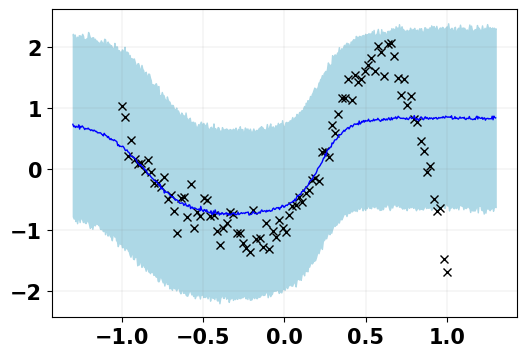

In [323]:
experiment = BasicFullRankGaussianVIExperiment(
    bnn,
    data,
    num_samples=2_500,
    max_iter=15_000,
)
experiment.run(random.PRNGKey(0))

### Sequential experiment

In [267]:
class SequentialExperiment(SequentialExperimentBlock):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data, Block: Type[SequentialExperimentBlock],
                 num_inference_steps: int = 2, **block_kwargs):
        """ :param num_inference_steps: split data into this many chunks, and
                                        do Bayesian inference sequentially on them
        """
        super().__init__(bnn, data)
        self._num_inference_steps = num_inference_steps
        self._Block: Type[SequentialExperimentBlock] = Block
        self._block_kwargs: dict = block_kwargs
        # Initialise state
        self._experiment_blocks: list[Block] = list()

    @property
    def posterior(self) -> tuple[dist.Distribution, dist.Distribution]:
        assert len(self._experiment_blocks) > 0
        return self._experiment_blocks[-1].posterior

    def train(self, rng_key_train: random.PRNGKey):
        train_len = self._data.train[0].shape[0]
        rng_key_array_train: random.PRNGKeyArray = random.split(rng_key_train, num=self._num_inference_steps)
        for step_idx, rng_key_train_step in enumerate(rng_key_array_train):
            # Create partial view decorator of data
            class DataView(Data):
                def __init__(self, data: Data, train_idx_slice: slice):
                    self._data = data
                    self._train_idx_slice: slice = train_idx_slice

                @property
                def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
                    X, Y = self._data.train
                    return X[self._train_idx_slice], Y[self._train_idx_slice]

                @property
                def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
                    return self._data.test

                def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
                    return self._data.true_predictive(X)

            chunk = slice(step_idx*(train_len//self._num_inference_steps),
                          min(train_len, (step_idx+1)*(train_len//self._num_inference_steps)))
            data_view = DataView(self._data, chunk)
            experiment_block = self._Block(self._bnn, data_view, **self._block_kwargs)
            experiment_block.train(rng_key_train_step)
            self._bnn.set_prior(*experiment_block.posterior)
            self._experiment_blocks.append(experiment_block)

    def make_predictions(self, rng_key_predict: random.PRNGKey, final_only: bool = True):
        # Delegate to final experiment block
        assert len(self._experiment_blocks) > 0
        if final_only:
            self._experiment_blocks[-1].make_predictions(rng_key_predict)
        else:
            rng_key_array: random.PRNGKeyArray = random.split(rng_key_predict, len(self._experiment_blocks))
            for experiment_block, rng_key in zip(self._experiment_blocks, rng_key_array):
                experiment_block.make_predictions(rng_key)

    def make_plots(self, final_only: bool = True) -> plt.Figure:
        # fig, ax = plt.subplots(nrows=len(self._experiment_blocks))
        assert len(self._experiment_blocks) > 0
        if final_only:
            return self._experiment_blocks[-1].make_plots()
        else:
            for experiment_block in self._experiment_blocks:
                experiment_block.make_plots()
        return None

## Space for running experiments

In [308]:
fresh_bnn = BayesianNeuralNetwork(
    nonlin=jnp.tanh,
    D_X=D_X,
    D_Y=1,
    D_H=5,
    L=3,
    biases=False
)

In [309]:
sequential_experiment = SequentialExperiment(fresh_bnn, permuted_data, BasicMeanFieldGaussianVIExperiment)

In [310]:
sequential_experiment.train(random.PRNGKey(0))

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/gabor/miniconda3/envs/bnn/lib/python3.10/site-packages/jax/linear_util.py:167: UserWarning: Missing a plate statement for batch dimension -1 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 5000/5000 [00:13<00:00, 367.40it/s, init loss: 444.2525, avg. loss [4751-5000]: 77.6634] 



SVI elapsed time: 14.892967939376831


100%|██████████| 5000/5000 [00:08<00:00, 599.18it/s, init loss: 346.4862, avg. loss [4751-5000]: 56.1451] 



SVI elapsed time: 9.60242772102356


In [311]:
sequential_experiment.make_predictions(random.PRNGKey(2), final_only=False)

In [312]:
sequential_experiment.make_plots(final_only=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [313]:
# Custom plotting for sequential experiment
fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
for i, ax in enumerate(axs.ravel()):
    experiment_block = sequential_experiment._experiment_blocks[i]
    predictions = experiment_block._predictions
    data = experiment_block._data
    X, Y = data.train
    X_test, _ = data.test
    # compute mean prediction and confidence interval around median
    mean_predictions = jnp.mean(predictions, axis=0)
    percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
    # plot training data
    ax.plot(X[:, 1], Y[:, 0], "kx")
    # plot predictions & quantiles
    ax.plot(X_test[:, 1], mean_predictions, color="blue")
    ax.fill_between(X_test[:, 1], *percentiles, color="lightblue")
    ax.set_title(str(data._train_idx_slice))
fig.tight_layout()
# fig.savefig("figs/sequential-randomized-VI-simple1.png")

<IPython.core.display.Javascript object>

#### Reverse dataset for two halves sequential experiment

In [276]:
fresh_bnn = BayesianNeuralNetwork(
    nonlin=jnp.tanh,
    D_X=D_X,
    D_Y=1,
    D_H=5,
    L=3,
    biases=False
)

In [277]:
reversed_data = ReverseData(data)

In [279]:
reversed_sequential_experiment = SequentialExperiment(fresh_bnn, reversed_data, BasicFullRankGaussianVIExperiment)

In [280]:
reversed_sequential_experiment.train(random.PRNGKey(0))

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/gabor/miniconda3/envs/bnn/lib/python3.10/site-packages/jax/linear_util.py:167: UserWarning: Missing a plate statement for batch dimension -1 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 5000/5000 [00:13<00:00, 362.94it/s, init loss: 263.4321, avg. loss [4751-5000]: 94.0140] 



SVI elapsed time: 14.874267101287842


100%|██████████| 5000/5000 [00:11<00:00, 447.30it/s, init loss: 190.1273, avg. loss [4751-5000]: 72.1658]



SVI elapsed time: 12.268781900405884


In [281]:
reversed_sequential_experiment.make_predictions(random.PRNGKey(1), final_only=False)

In [282]:
# Custom plotting for reversed sequential experiment
fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
for i, ax in enumerate(axs.ravel()):
    experiment_block = reversed_sequential_experiment._experiment_blocks[i]
    predictions = experiment_block._predictions
    data = experiment_block._data
    X, Y = data.train
    X_test, _ = data.test
    # compute mean prediction and confidence interval around median
    mean_predictions = jnp.mean(predictions, axis=0)
    percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
    # plot training data
    ax.plot(X[:, 1], Y[:, 0], "kx")
    # plot predictions & quantiles
    ax.plot(X_test[:, 1], mean_predictions, color="blue")
    ax.fill_between(X_test[:, 1], *percentiles, color="lightblue")
    ax.set_title(str(data._train_idx_slice))
fig.tight_layout()
# fig.savefig("figs/sequential-full-rank-VI-reversed1.png")

<IPython.core.display.Javascript object>

#### Randomized dataset experiment

In [307]:
train_len = data.train[0].shape[0]
random_perm = np.random.choice(np.arange(train_len), size=train_len, replace=False)
permuted_data = PermutedData(data, random_perm)

In [17]:
plt.close('all')